# Neural Network Model Tuning

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is with new features and hyperparameter tuning on Neural Network

# Table of Contents

### - [Neural Net Architecture](#NN)

### - [SHAP Values for Feature Importance](#SHAP)

### - [HyperParemeter Tuning with Grid Search](#GRID)

### - [Best Model Results](#RESULTS)

### - [Confusion Matrix](#matrix)

### - [Prior Iterations](#prior)

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [2]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle

# # visualization libraries
from matplotlib import pyplot as plt
# plt.style.use('bmh')
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

import torch
import torch.nn as nn
import torch.optim as optim
import shap

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

2

In [5]:
torch.device('cuda')

device(type='cuda')

In [6]:
X_train, X_test, y_train, y_test = pickle.load(open("../../data/train_test_data.pkl", "rb"))

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("\n")
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (863, 13)
X_test:  (215, 13)


y_train:  (863,)
y_test:  (215,)


## Neural Net <a id="NN">

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.relu3 = nn.ReLU()
#         self.dropout3 = nn.Dropout(dropout_rate) # dropout to prevent overfitting

#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         self.relu4 = nn.ReLU()
#         self.dropout4 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # output to probability rather than bool
        
        # Initilize weights with Glorot
        # need to decide on uniform vs normal distribution
        # UNIFORM
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.xavier_uniform_(self.fc3.weight)
        # nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        
        # NORMAL
        # nn.init.xavier_normal_(self.fc1.weight)
        # nn.init.xavier_normal_(self.fc2.weight)
        # nn.init.xavier_normal_(self.fc3.weight)
        # nn.init.xavier_normal_(self.fc4.weight)
        # nn.init.xavier_normal_(self.fc_out.weight)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
#         out = self.fc3(out)
#         out = self.relu3(out)
#         out = self.dropout3(out)
        
#         out = self.fc4(out)
#         out = self.relu4(out)
#         out = self.dropout4(out)
        
        out = self.fc_out(out)
        out = self.sigmoid(out)      

        return out

Grid Search HyperParameters

In [8]:
n_epochs = 500

In [9]:
%%time
# GRID SEARCH CV

# 15 MIN
if __name__ == '__main__':
    # data already loaded

    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 50, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    for params in ParameterGrid(param_grid):
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        output_size = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['lr']

        model = Net(input_size, hidden_size, output_size, dropout_rate)

        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
        
        # best_params = grid_search.best_params_
        # best_model = grid_search.best_estimator_
     
        num_epochs = n_epochs

        # # empty df to track loss over epochs
        # loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])

        for epoch in range(num_epochs):
            y_train_pred = model(X_train)
            loss = criterion(y_train_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
#         if epoch%5 ==0:
#             y_train_pred = model(X_train)
#             y_test_pred = model(X_test)

#             train_loss = criterion(y_train_pred, y_train)
#             val_loss = criterion(y_test_pred, y_test)
            
#             loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
#             loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

# fig = loss_df.plot()
# fig.set_xlabel('epochs')
# fig.set_ylabel('loss')
# fig.set_title('Loss over Epochs');

        # now "final" outputs
        y_train_pred = model(X_train)
        #y_train_prob = torch.sigmoid(y_train_pred) # already a probability

        y_test_pred = model(X_test)
        # y_test_prob = torch.sigmoid(y_test_pred) # already a probability

        train_loss = criterion(y_train_pred, y_train)
        val_loss = criterion(y_test_pred, y_test)

        test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
        test_accuracy = (test_pred_correct / y_test.shape[0])[0]
        
        test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
        
        # extract AUC for printing
        auc_test = roc_auc_score(
            y_test.detach().numpy(), 
            y_test_pred.detach().numpy()
        )
        
#         # evaluating parameters on test accuracy
#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             best_params = params

#         # evaluating parameters on test recall
#         if test_recall_score > best_recall:
#             best_recall = test_recall_score
#             best_params = params
        
        # evaluating parameters on test AUC
        if auc_test > best_auc:
            best_auc = auc_test
            best_params = params

    # save final model weights
    # torch.save(model.state_dict(), 'model.pth')     
    
    print('best hyperparameters:')
    print(best_params)
    
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')

    print("\n")

    # accuracy
    train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
    train_accuracy = (train_pred_correct / y_train.shape[0])[0]
    print(f'Training accuracy: {train_accuracy}')

    test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
    test_accuracy = (test_pred_correct / y_test.shape[0])[0]
    print(f'Test accuracy: {test_accuracy}')
    
    # Recall
    print("\n")
    print(f'Test Recall: {test_recall_score}')
    
    # AUC
    print("\n")
    print(f'Test AUC: {auc_test}')
    # f1
    f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
    print("\n")
    print(f'Test F1 Score: {f1_output}')

best hyperparameters:
{'dropout_rate': 0.1, 'hidden_size': 500, 'lr': 0.01}
Training loss: 0.02248380333185196
Validation loss: 1.036694884300232


Training accuracy: 0.9953650057937428
Test accuracy: 0.8790697674418605


Test Recall: 0.7213114754098361


Test AUC: 0.9342133276559507


Test F1 Score: 0.7719298245614035
CPU times: user 4h 54min 19s, sys: 3min 23s, total: 4h 57min 42s
Wall time: 16min 42s


- 2 hidden layers 
- all features
- 500 epochs
- optimized on AUC

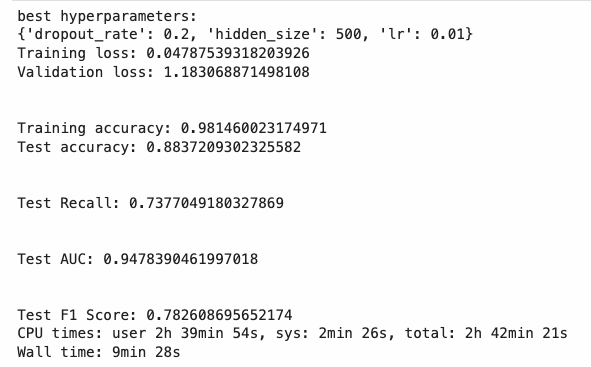

In [ ]:
# torch.save(model.state_dict(), "../../model/df_model_two_hidden_all_features.pth")

# SKIP TO "BEST MODEL" SECTION

In [11]:
print(n_epochs)

500


## SHAP Values <a id="SHAP">
    
Examine the Shap values for feature importance
- we likely need to reduce the number of features to prevent overfitting

In [12]:
explainer = shap.DeepExplainer(model, X_train)

In [13]:
shap_values = explainer.shap_values(X_test)
shap_values

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([[-0.13055448, -0.00688359, -0.06727079, ...,  0.00608442,
        -0.00142732, -0.03412893],
       [-0.13456675, -0.01108537, -0.07496445, ...,  0.00326242,
         0.00032429, -0.01296831],
       [-0.13651988, -0.00366365, -0.06637111, ...,  0.0037224 ,
        -0.00275876, -0.0429724 ],
       ...,
       [-0.12452775, -0.00619775, -0.04235835, ..., -0.00727576,
        -0.00244159, -0.03319829],
       [-0.11463913, -0.00712074, -0.0444166 , ..., -0.00850294,
        -0.00216668, -0.03584787],
       [-0.12728748, -0.00216009, -0.08117879, ...,  0.02029909,
        -0.00416113, -0.04087821]])

In [14]:
shap_values.shape

(215, 13)

In [15]:
vals = np.abs(shap_values).mean(0)
vals

array([0.12444342, 0.02034176, 0.04884374, 0.03026771, 0.0161429 ,
       0.04092045, 0.03595635, 0.02013219, 0.03957238, 0.01753531,
       0.02961767, 0.03531959, 0.07341457])

In [17]:
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

In [18]:
shap_val_df = pd.DataFrame(data=vals, index=X_test_df.columns, columns=['vals'])
shap_val_df = shap_val_df.sort_values(by='vals', ascending=False)
shap_val_df

,vals
peak_i15_mmh,0.124443
SuscFrac,0.073415
prophm23,0.048844
Fine fuel load,0.040920
Extinction moisture content,0.039572
SAV,0.035956
SedUn,0.035320
dnbr1000,0.030268
fire_interval,0.029618
contributingarea_km2,0.020342


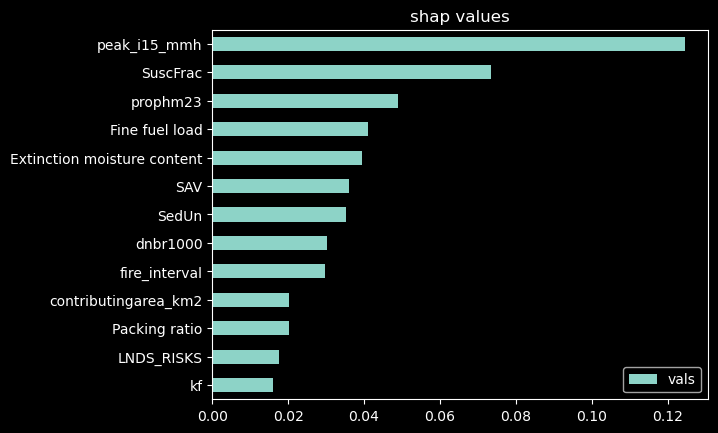

In [19]:
shap_val_df[::-1].plot(kind='barh', title='shap values');

In [20]:
feat_order = list(shap_val_df.index)
feat_order

['peak_i15_mmh',
 'SuscFrac',
 'prophm23',
 'Fine fuel load',
 'Extinction moisture content',
 'SAV',
 'SedUn',
 'dnbr1000',
 'fire_interval',
 'contributingarea_km2',
 'Packing ratio',
 'LNDS_RISKS',
 'kf']

In [24]:
# generate incrementally longer feature lists in order of importance
cumulative_feature_list = []
for i, feat in enumerate(feat_order, 1):
    cumulative_feature_list.append(feat_order[:i])
# just check the first few records to make sure they increment by one
cumulative_feature_list[:4]

[['peak_i15_mmh'],
 ['peak_i15_mmh', 'SuscFrac'],
 ['peak_i15_mmh', 'SuscFrac', 'prophm23'],
 ['peak_i15_mmh', 'SuscFrac', 'prophm23', 'Fine fuel load']]

In [25]:
# and the last one
# looks good
cumulative_feature_list[-1]

['peak_i15_mmh',
 'SuscFrac',
 'prophm23',
 'Fine fuel load',
 'Extinction moisture content',
 'SAV',
 'SedUn',
 'dnbr1000',
 'fire_interval',
 'contributingarea_km2',
 'Packing ratio',
 'LNDS_RISKS',
 'kf']

In [ ]:
# feats = feat_order[:5]
# feats

In [26]:
# in case you want to limit it, uncomment the list slice
feat_of_feats = cumulative_feature_list#[:10]
feat_of_feats[-1]

['peak_i15_mmh',
 'SuscFrac',
 'prophm23',
 'Fine fuel load',
 'Extinction moisture content',
 'SAV',
 'SedUn',
 'dnbr1000',
 'fire_interval',
 'contributingarea_km2',
 'Packing ratio',
 'LNDS_RISKS',
 'kf']

## Grid Search HyperParameter Tuning <a id="GRID">

In [44]:
n_epochs = 500

In [50]:
%%time
# GRID SEARCH CV with feature selection

# 15 MIN
if __name__ == '__main__':

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 50, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    'features': feat_of_feats # list of lists
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    for params in ParameterGrid(param_grid):
        
        # Load data
        
        # splitting already conducted
        # using df objects to avoid tensor issues
        X_train = X_train_df[params['features']]
        X_test = X_test_df[params['features']]
        y_train = y_train_df
        y_test = y_test_df

        #scale the data X_train and X_test
        cols = X_train.columns
        sc = StandardScaler()
        X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
        X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

        X_train = torch.tensor(X_train.values).float()
        y_train = torch.tensor(y_train.values).float().view(-1, 1)
        X_test = torch.tensor(X_test.values).float()
        y_test = torch.tensor(y_test.values).float().view(-1, 1)
        
        
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        output_size = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['lr']

        model = Net(input_size, hidden_size, output_size, dropout_rate)

        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
        
        # best_params = grid_search.best_params_
        # best_model = grid_search.best_estimator_
     
        num_epochs = n_epochs

        # # empty df to track loss over epochs
        # loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])

        for epoch in range(num_epochs):
            y_train_pred = model(X_train)
            loss = criterion(y_train_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
#         if epoch%5 ==0:
#             y_train_pred = model(X_train)
#             y_test_pred = model(X_test)

#             train_loss = criterion(y_train_pred, y_train)
#             val_loss = criterion(y_test_pred, y_test)
            
#             loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
#             loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

# fig = loss_df.plot()
# fig.set_xlabel('epochs')
# fig.set_ylabel('loss')
# fig.set_title('Loss over Epochs');

        # now "final" outputs
        y_train_pred = model(X_train)
        #y_train_prob = torch.sigmoid(y_train_pred) # already a probability

        y_test_pred = model(X_test)
        # y_test_prob = torch.sigmoid(y_test_pred) # already a probability

        train_loss = criterion(y_train_pred, y_train)
        val_loss = criterion(y_test_pred, y_test)

        test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
        test_accuracy = (test_pred_correct / y_test.shape[0])[0]

        test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
        
        # extract AUC for printing
        auc_test = roc_auc_score(
            y_test.detach().numpy(), 
            y_test_pred.detach().numpy()
        )
        
        # # evaluating parameters on test accuracy
        # if test_accuracy > best_accuracy:
        #     best_accuracy = test_accuracy
        #     best_params = params

        # # evaluating parameters on test recall
        # if test_recall_score > best_recall:
        #     best_recall = test_recall_score
        #     best_params = params

        # evaluating parameters on test AUC
        if auc_test > best_auc:
            best_auc = auc_test
            best_params = params

    # save final model weights
    # torch.save(model.state_dict(), 'model.pth')     
    
    print('with feature selection')
    print('best hyperparameters:')
    print(best_params)
    
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')

    print("\n")

    # accuracy
    train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
    train_accuracy = (train_pred_correct / y_train.shape[0])[0]
    print(f'Training accuracy: {train_accuracy}')

    test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
    test_accuracy = (test_pred_correct / y_test.shape[0])[0]
    print(f'Test accuracy: {test_accuracy}')
    
    # recall
    test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
    print("\n")
    print(f'Test Recall: {test_recall_score}')    
    
    # AUC
    print("\n")
    print(f'Test AUC): {auc_test}')
    # f1
    f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
    print(f'Test F1 Score: {f1_output}')

with feature selection
best hyperparameters:
{'dropout_rate': 0.2, 'features': ['peak_i15_mmh', 'SuscFrac', 'prophm23', 'Fine fuel load', 'Extinction moisture content', 'SAV', 'SedUn', 'dnbr1000', 'fire_interval', 'contributingarea_km2', 'Packing ratio', 'LNDS_RISKS', 'kf'], 'hidden_size': 100, 'lr': 0.01}
Training loss: 0.028424743562936783
Validation loss: 1.2984790802001953


Training accuracy: 0.9907300115874855
Test accuracy: 0.8697674418604651


Test Recall: 0.7049180327868853


Test AUC): 0.9291569086651055
Test F1 Score: 0.7543859649122806
CPU times: user 2d 3h 33min 15s, sys: 31min 58s, total: 2d 4h 5min 14s
Wall time: 2h 56min 9s


500 epochs, grid/feature search

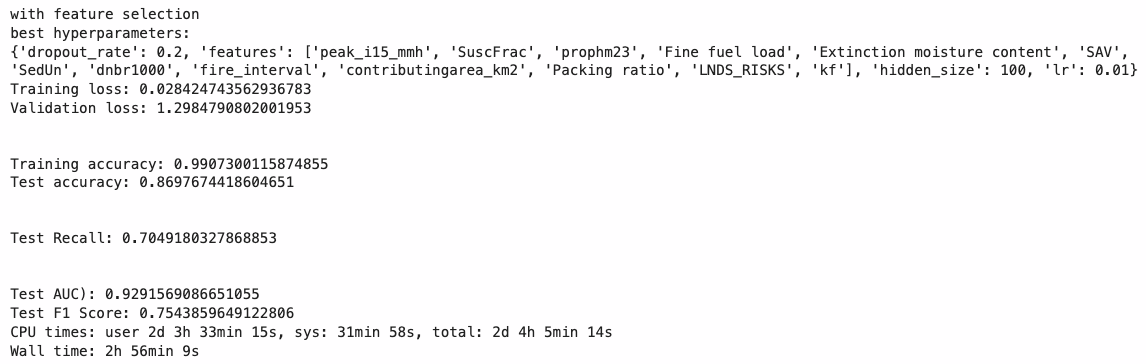

In [51]:
len(best_params['features'])

13

In [52]:
best_params

{'dropout_rate': 0.2,
 'features': ['peak_i15_mmh',
  'SuscFrac',
  'prophm23',
  'Fine fuel load',
  'Extinction moisture content',
  'SAV',
  'SedUn',
  'dnbr1000',
  'fire_interval',
  'contributingarea_km2',
  'Packing ratio',
  'LNDS_RISKS',
  'kf'],
 'hidden_size': 100,
 'lr': 0.01}

In [53]:
print(n_epochs)

500


## Best Model <a id="RESULTS">
    
- experiment with number of epochs

USE WITH ALL FEATURES

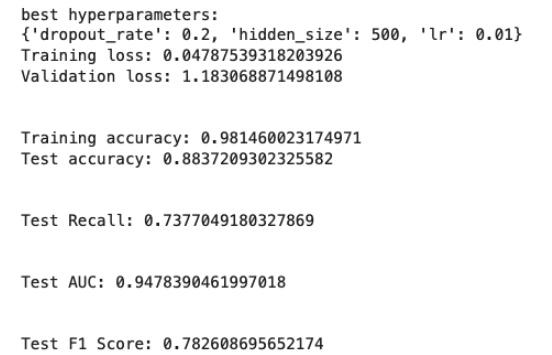

In [15]:
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

In [16]:
params = {
    'dropout_rate': 0.2,
     'features': [
        'peak_i15_mmh',
         'SuscFrac',
         'prophm23',
         'Fine fuel load',
         'Extinction moisture content',
         'SAV',
         'SedUn',
         'dnbr1000',
         'fire_interval',
         'contributingarea_km2',
         'Packing ratio',
         'LNDS_RISKS',
         'kf'],
     'hidden_size': 500,
     'lr': 0.01
}

input_size = len(params['features'])
hidden_size = params['hidden_size']
output_size = 1
dropout_rate = params['dropout_rate']
learning_rate = params['lr']

In [17]:
# useful for upsizing number of epochs while testing

n_epochs = n_epochs
#n_epochs = 100
#n_epochs = 250
n_epochs = 500
#n_epochs = 1_000
#n_epochs = 5_000
#n_epochs = 10_000

hyperparameters:
{'dropout_rate': 0.2, 'features': ['peak_i15_mmh', 'SuscFrac', 'prophm23', 'Fine fuel load', 'Extinction moisture content', 'SAV', 'SedUn', 'dnbr1000', 'fire_interval', 'contributingarea_km2', 'Packing ratio', 'LNDS_RISKS', 'kf'], 'hidden_size': 500, 'lr': 0.01}
epochs:  500


Training loss: 0.0223323293030262
Validation loss: 0.9137507081031799


Training accuracy: 0.9907300115874855
Test accuracy: 0.8790697674418605


Recall (test): 0.6885245901639344


F1 Score (test): 0.7636363636363637
AUC (test): 0.937087502661273


CPU times: user 6min 26s, sys: 2.89 s, total: 6min 29s
Wall time: 23.9 s


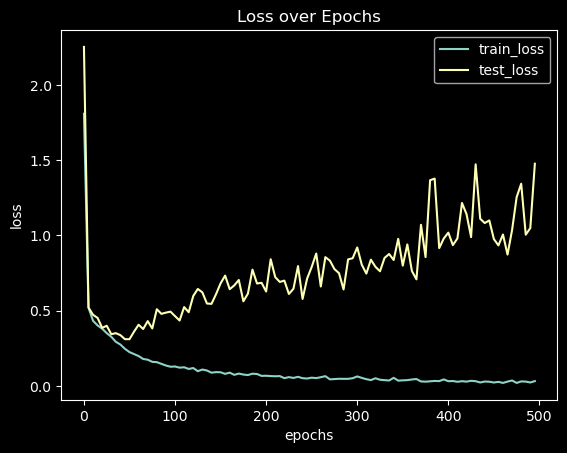

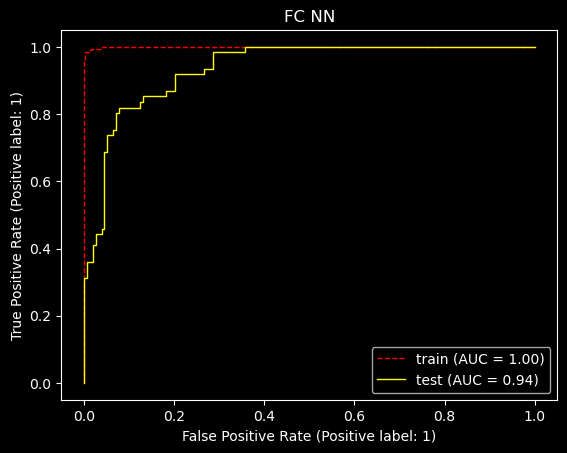

In [19]:
%%time
# 15 MIN
if __name__ == '__main__':

    # Load data

    # splitting already conducted
    # using df objects to avoid tensor issues
    X_train = X_train_df[params['features']]
    X_test = X_test_df[params['features']]
    y_train = y_train_df
    y_test = y_test_df

    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = best_params['hidden_size']
    output_size = 1
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['lr'] # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = n_epochs
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')


print('hyperparameters:')
print(best_params)
print('epochs: ', n_epochs)

print("\n")

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# recall
test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
print('\n')
print(f'Recall (test): {test_recall_score}')


# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN');

In [21]:
print(model)

Net(
  (fc1): Linear(in_features=13, out_features=500, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [32]:
torch.save(model.state_dict(), "../../model/df_model_two_hidden_all_features.pth")

In [23]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.6453, -0.1691, -0.0790,  ..., -0.1990, -0.0058, -0.5429],
                      [ 0.0419, -0.0388, -0.2009,  ...,  0.0433,  0.0103, -0.0203],
                      [-0.6863, -0.2852, -0.1444,  ...,  0.1098, -0.0012,  0.5172],
                      ...,
                      [-0.2397,  0.0138, -0.3948,  ...,  0.1297,  0.0337, -0.4684],
                      [-0.2697,  0.1110, -0.0633,  ...,  0.1298,  0.0287,  0.0715],
                      [-0.1903, -0.1589,  0.1377,  ..., -0.0380, -0.2286,  0.4075]])),
             ('fc1.bias',
              tensor([-0.1893, -0.1982, -0.3178, -0.4000, -0.4468, -0.3051, -0.2049, -0.1173,
                       0.0443, -0.7022, -0.3569, -0.0079, -0.0619, -0.5077, -0.6863, -0.5370,
                      -0.5150, -0.1011, -0.4981, -0.1586, -0.7202, -0.7674, -0.1626, -0.1197,
                      -0.1027, -0.1054,  0.1838, -0.8515, -0.0677, -0.4206, -0.1250, -0.0030,
                      -0.5913, -0.40

In [24]:
optimizer.state_dict()

{'state': {0: {'step': tensor(500.),
   'exp_avg': tensor([[ 2.6550e-05, -5.1324e-05, -1.1537e-04,  ..., -1.4812e-05,
             1.7659e-05,  2.0838e-05],
           [-2.4036e-04, -1.1433e-04,  7.3755e-05,  ..., -5.5521e-05,
            -5.3111e-05,  1.4324e-05],
           [ 1.0158e-04, -6.8494e-05,  1.0814e-05,  ..., -1.6243e-04,
             2.9083e-06,  4.0972e-06],
           ...,
           [ 2.7155e-05, -2.0903e-04,  5.2047e-05,  ...,  3.0686e-05,
            -1.5092e-04, -2.9943e-06],
           [ 1.2065e-04, -1.0616e-05,  1.6282e-04,  ..., -2.0091e-04,
             7.4373e-05, -4.3840e-06],
           [ 5.4561e-05, -1.3261e-04, -8.7385e-05,  ..., -8.9329e-05,
             1.0318e-04,  3.2051e-06]]),
   'exp_avg_sq': tensor([[3.1467e-07, 1.1231e-06, 8.4635e-07,  ..., 4.3681e-07, 1.9993e-07,
            2.0533e-08],
           [1.3611e-06, 2.7071e-07, 2.5001e-07,  ..., 1.0951e-06, 1.0497e-06,
            6.0983e-08],
           [2.1954e-07, 6.9627e-07, 5.1048e-07,  ..., 5.0849

In [25]:
pd.DataFrame(np.round(y_test_pred.detach().numpy())).value_counts(normalize=True)

0.0    0.772093
1.0    0.227907
dtype: float64

## Assess the wrong predictions <a id="matrix">
- is the loss for test set high due to outliers?

In [26]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)

In [27]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test.detach().numpy(), columns=['y_test']).astype(int)
# predicted values
test_assess['y_test_pred'] = np.round(y_test_pred.detach().numpy()).astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred.detach().numpy()
test_assess

,y_test,y_test_pred,pred_correct,y_test_pred_proba
0,0,0,True,0.0000000
1,0,0,True,0.0000000
2,0,0,True,0.0000000
3,0,0,True,0.0000000
4,0,0,True,0.0000000
...,...,...,...,...
210,0,0,True,0.0000000
211,0,0,True,0.0000000
212,0,0,True,0.0000000
213,0,0,True,0.0000000


In [28]:
test_assess[['y_test']].value_counts(normalize=True)

y_test
0        0.7162791
1        0.2837209
dtype: float64

In [29]:
test_assess['y_test_pred'].value_counts(normalize=True)

0   0.7720930
1   0.2279070
Name: y_test_pred, dtype: float64

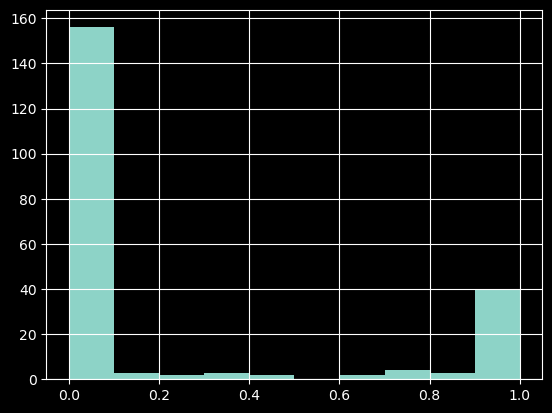

In [30]:
test_assess['y_test_pred_proba'].hist();

In [31]:
# the confusion matrix is OK, better than any other we've produced so far
test_assess.groupby(['y_test'])['pred_correct'].value_counts().unstack()

pred_correct,False,True
y_test,,
0,7,147
1,19,42


In [42]:
# check geographical distribution of test set labels
df.loc[y_test.index,'pred_correct'] = y_test == y_test_pred

df.groupby(['state'])['pred_correct'].value_counts(normalize=True).unstack().fillna(0).style.format("{:,.1%}")

AttributeError: 'Tensor' object has no attribute 'index'

In [ ]:
23 / (23 + 30)

prior to recall optimization

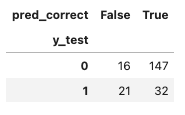

In [ ]:
21 / (21 + 32)

In [ ]:
pd.DataFrame(y_test_pred.detach().numpy()).hist();

prior to recall optimization

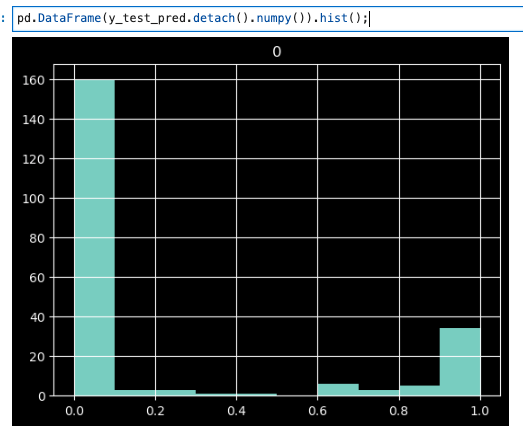

In [ ]:
# let's examine the probability of these false negatives
false_negatives = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]
false_negatives

In [ ]:
# the false negatives have really low predicted probabilities
false_negatives['y_test_pred_proba'].plot(kind='hist');

prior to recall optimization

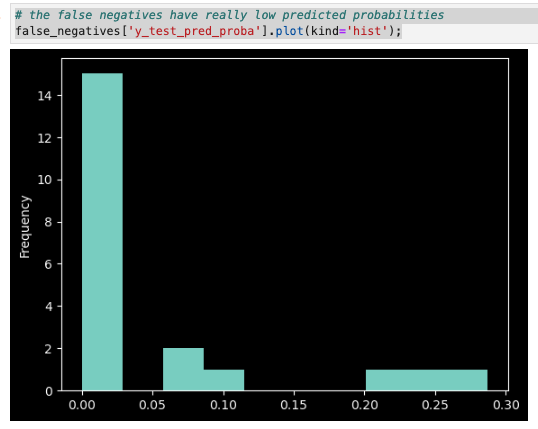

## Prior Iterations <a id="prior"> 

- we had higher AUC but also higher False Negatives.
- trying to strike balance between model scalability, performance, and preventing false negatives.
    - We don't need to include details on this in the report

In [ ]:
# let's do the same assessment with our previous model iteration that had low test_loss

In [276]:
n_epochs = 100

In [277]:
%%time
# GRID SEARCH CV

# 15 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()

    X = data[features_15[:-2]] # exclude the two additional features
    y = data['response']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    for params in ParameterGrid(param_grid):
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        output_size = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['lr']

        model = Net(input_size, hidden_size, output_size, dropout_rate)

        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
        
        # best_params = grid_search.best_params_
        # best_model = grid_search.best_estimator_
     
        num_epochs = n_epochs

        # # empty df to track loss over epochs
        # loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])

        for epoch in range(num_epochs):
            y_train_pred = model(X_train)
            loss = criterion(y_train_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
#         if epoch%5 ==0:
#             y_train_pred = model(X_train)
#             y_test_pred = model(X_test)

#             train_loss = criterion(y_train_pred, y_train)
#             val_loss = criterion(y_test_pred, y_test)
            
#             loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
#             loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

# fig = loss_df.plot()
# fig.set_xlabel('epochs')
# fig.set_ylabel('loss')
# fig.set_title('Loss over Epochs');

        # now "final" outputs
        y_train_pred = model(X_train)
        #y_train_prob = torch.sigmoid(y_train_pred) # already a probability

        y_test_pred = model(X_test)
        # y_test_prob = torch.sigmoid(y_test_pred) # already a probability

        train_loss = criterion(y_train_pred, y_train)
        val_loss = criterion(y_test_pred, y_test)

        test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
        test_accuracy = (test_pred_correct / y_test.shape[0])[0]
        
        test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='micro')

        # extract AUC for printing
        auc_test = roc_auc_score(
            y_test.detach().numpy(), 
            y_test_pred.detach().numpy()
        )
        
        # # evaluating parameters on test accuracy
        # if test_accuracy > best_accuracy:
        #     best_accuracy = test_accuracy
        #     best_params = params
            
        # evaluating parameters on test recall
        if test_recall_score > best_recall:
            best_recall = test_recall_score
            best_params = params
            
        # # evaluating parameters on test AUC
        # if auc_test > best_auc:
        #     best_auc = auc_test
        #     best_params = params

    # save final model weights
    # torch.save(model.state_dict(), 'model.pth')     
    
    print('best hyperparameters:')
    print(best_params)
    
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')

    print("\n")

    # accuracy
    train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
    train_accuracy = (train_pred_correct / y_train.shape[0])[0]
    print(f'Training accuracy: {train_accuracy}')

    test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
    test_accuracy = (test_pred_correct / y_test.shape[0])[0]
    print(f'Test accuracy: {test_accuracy}')

    # AUC
    print("\n")
    print(f'AUC (test): {auc_test}')
    # f1
    f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
    print(f'F1 Score (test): {f1_output}')

best hyperparameters:
{'dropout_rate': 0.05, 'hidden_size': 100, 'lr': 0.01}
Training loss: 0.15981507301330566
Validation loss: 0.470291405916214


Training accuracy: 0.9322617680826636
Test accuracy: 0.8211009174311926


AUC (test): 0.887707261292167
F1 Score (test): 0.6666666666666665
CPU times: user 4min 47s, sys: 3.53 s, total: 4min 51s
Wall time: 14.4 s


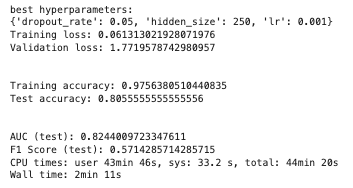

In [278]:
# # previously tuned parameters that worked well
# best_params = {
#     'dropout_rate': 0.05,
#     'hidden_size': 10,
#     'lr': 0.0001
# }

In [279]:
n_epochs = 5_000

hyperparameters:
{'dropout_rate': 0.05, 'hidden_size': 100, 'lr': 0.01}
epochs:  5000


Training loss: 0.0456533245742321
Validation loss: 2.376729726791382


Training accuracy: 0.983926521239954
Test accuracy: 0.7889908256880734


F1 Score (test): 0.6034482758620691
AUC (test): 0.8600343053173242


CPU times: user 5min 8s, sys: 2.93 s, total: 5min 11s
Wall time: 14.5 s


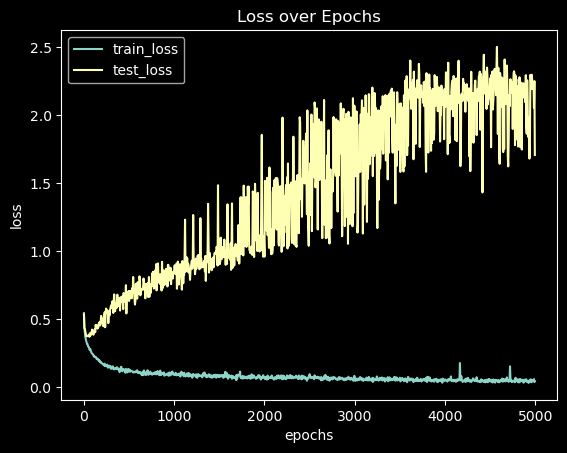

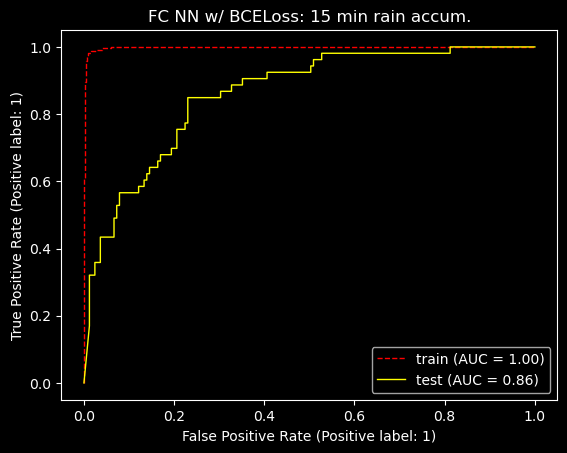

In [280]:
%%time
# 15 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    X = data[features_15[:-2]]
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = best_params['hidden_size']
    output_size = 1
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['lr'] # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = n_epochs
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')


print('hyperparameters:')
print(best_params)
print('epochs: ', n_epochs)

print("\n")

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 15 min rain accum.');

In [281]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test.detach().numpy(), columns=['y_test']).astype(int)
# predicted values
test_assess['y_test_pred'] = np.round(y_test_pred.detach().numpy()).astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred.detach().numpy()
test_assess

,y_test,y_test_pred,pred_correct,y_test_pred_proba
0,1,0,False,0.0419769
1,0,0,True,0.0000000
2,0,1,False,0.9837437
3,0,0,True,0.0000003
4,0,1,False,0.9499037
...,...,...,...,...
213,1,0,False,0.4699014
214,0,1,False,0.7389097
215,1,1,True,0.9871778
216,0,0,True,0.0000000


In [282]:
# the confusion matrix is really pretty bad
# even more false negatives!
test_assess.groupby(['y_test'])['pred_correct'].value_counts().unstack()

pred_correct,False,True
y_test,,
0,28,137
1,18,35


with "macro" average (does not take class imbalance into account)

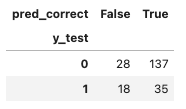

with "micro" average

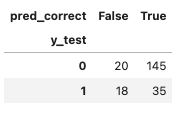

In [271]:
18 / (18+35)

0.33962264150943394

with "binary" average

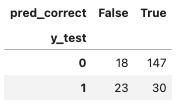

In [264]:
23 / (23 + 30)

0.4339622641509434

before maximing recall

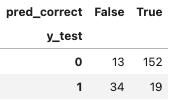

In [262]:
# let's examine the probability of these false negatives
false_negatives = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]
false_negatives

,y_test,y_test_pred,pred_correct,y_test_pred_proba
16,1,0,False,0.3881507
43,1,0,False,0.2440847
45,1,0,False,0.0770734
51,1,0,False,0.3869691
53,1,0,False,0.3794882
66,1,0,False,0.0192388
67,1,0,False,0.4561952
69,1,0,False,0.3699151
73,1,0,False,0.4835797
80,1,0,False,0.3902963


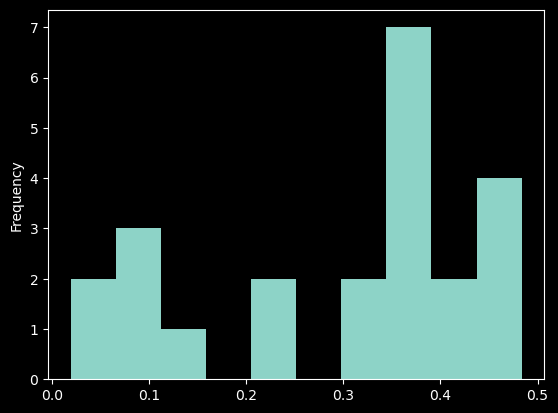

In [263]:
# the false negatives have really low predicted probabilities
false_negatives['y_test_pred_proba'].plot(kind='hist');

10,000 epochs with 1 hidden layer, before landslide risk

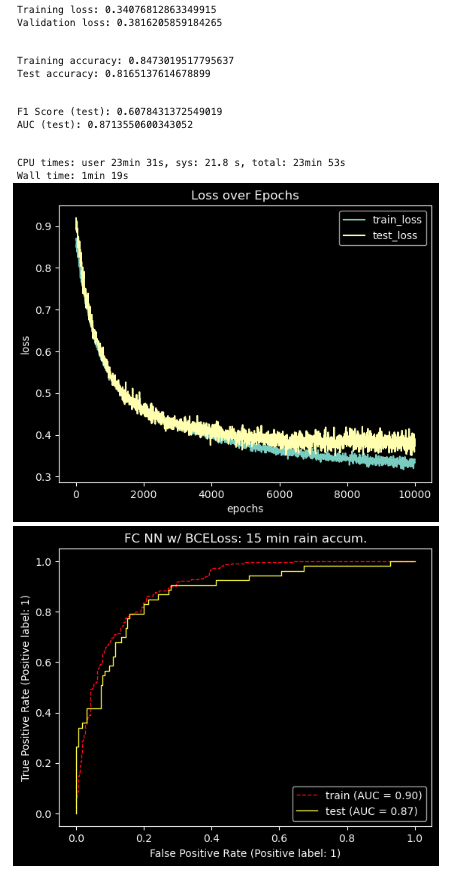

 1,000 epochs
 
 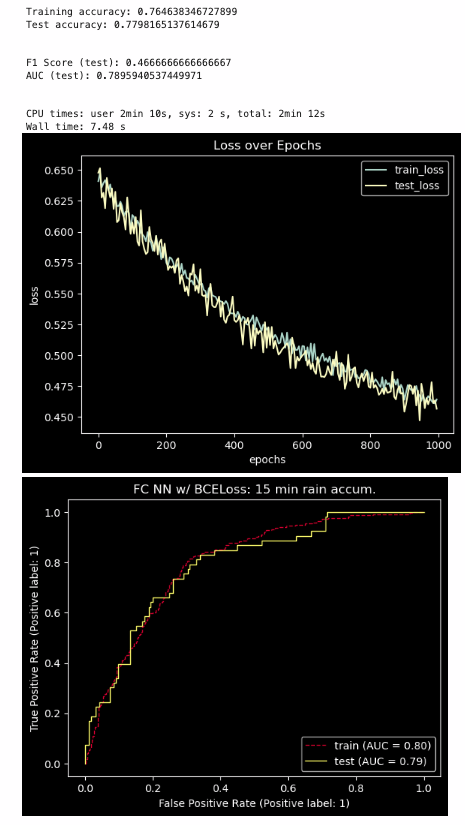

Training loss: 0.018063928931951523
Validation loss: 2.569516897201538


Training accuracy: 0.9919632606199771
Test accuracy: 0.8211009174311926


F1 Score (test): 0.6548672566371682
AUC (test): 0.869182389937107


CPU times: user 4min 46s, sys: 6.38 s, total: 4min 52s
Wall time: 14.1 s


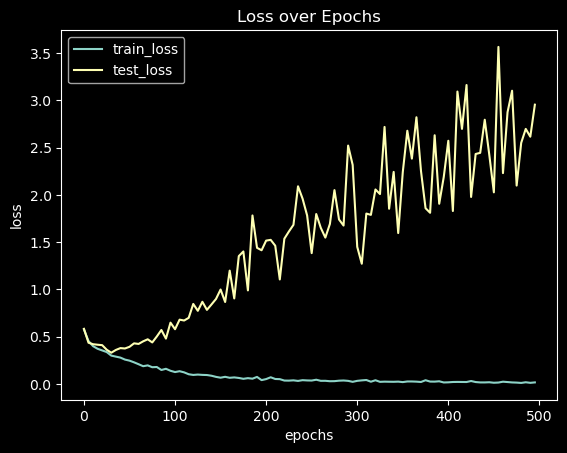

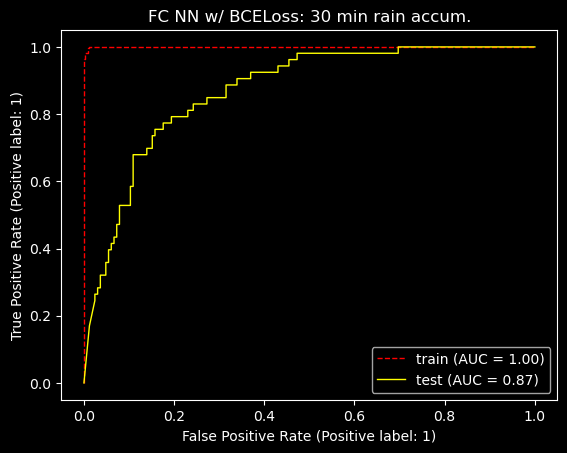

In [11]:
%%time
# 30 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    X = data[features_30]
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
       
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 500
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 30 min rain accum.');

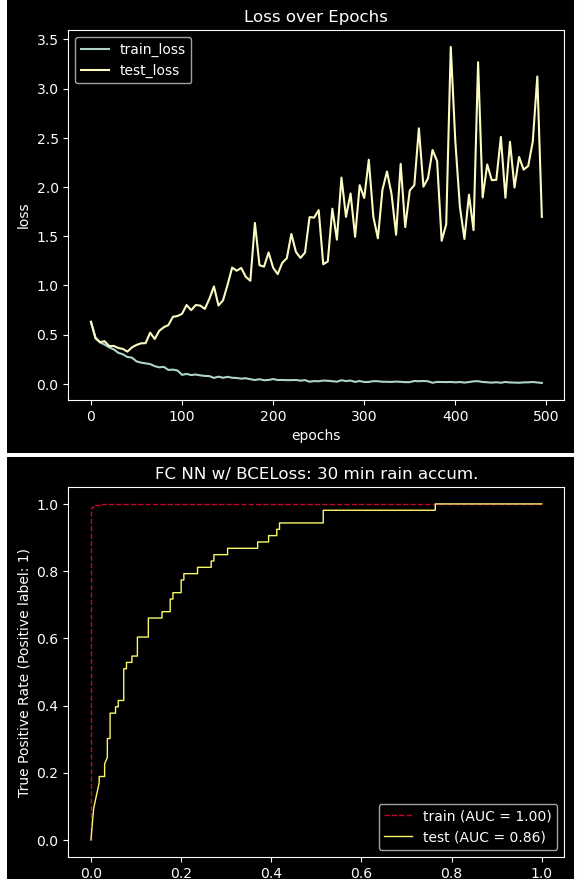

Training loss: 0.01925519108772278
Validation loss: 1.5104376077651978


Training accuracy: 0.9873708381171068
Test accuracy: 0.7935779816513762


F1 Score (test): 0.5945945945945946
AUC (test): 0.8695254431103487


CPU times: user 25min 25s, sys: 25 s, total: 25min 50s
Wall time: 1min 38s


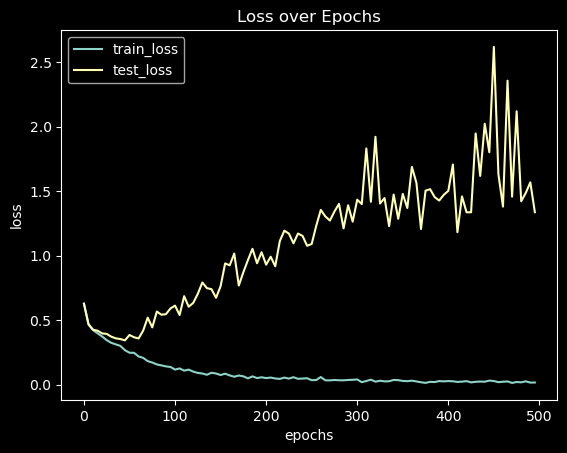

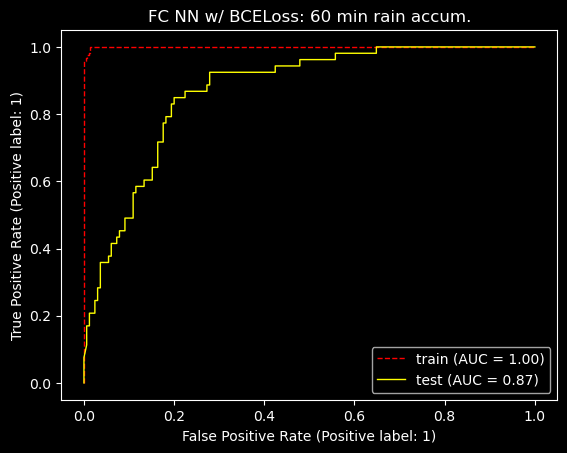

In [16]:
%%time
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    X = data[features_60]
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
        
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 500
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum.');